In [1]:
# --- CELL 1: THIẾT LẬP VÀ IMPORT THƯ VIỆN ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import warnings
import os

warnings.filterwarnings("ignore")

from xgboost import XGBClassifier
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, f1_score
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint
from pytorch_forecasting import TimeSeriesDataSet, TemporalFusionTransformer
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.metrics import QuantileLoss

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 7)
print("✅ Tất cả thư viện đã được import thành công!")

✅ Tất cả thư viện đã được import thành công!


In [2]:
# --- CELL 2: ĐỌC VÀ TỔNG HỢP DỮ LIỆU TỪ FILE THÔ ---
raw_file_path = r"C:\Users\nguye\CODE\TimeSeries\BTL\Data\Time_Data.csv"
aggregated_parquet_path = 'aggregated_final_data.parquet'

if os.path.exists(aggregated_parquet_path):
    print(f"Phát hiện file đã tổng hợp '{aggregated_parquet_path}'. Đang đọc trực tiếp...")
    df_agg_final = pd.read_parquet(aggregated_parquet_path)
    print("✅ Đọc file đã tổng hợp thành công!")
else:
    print("Không tìm thấy file đã tổng hợp. Bắt đầu xử lý lại từ file CSV 50GB...")
    chunks = pd.read_csv(raw_file_path, chunksize=10000000)
    all_chunks = []
    for chunk in tqdm(chunks):
        chunk['event_time'] = pd.to_datetime(chunk['event_time'])
        chunk['month'] = chunk['event_time'].dt.to_period('M').astype(str)
        agg = chunk.groupby(['user_id', 'month']).agg(
            event_count=('event_time', 'count'), total_spent=('price', 'sum'),
            purchase_count=('event_type', lambda x: (x == 'purchase').sum()),
            n_categories=('category_code', 'nunique'), churn=('churn', 'max')
        ).reset_index()
        all_chunks.append(agg)
    print("Đang gộp các chunk đã xử lý...")
    df_to_agg = pd.concat(all_chunks)
    final_aggregation_rules = {
        'event_count': 'sum', 'total_spent': 'sum',
        'purchase_count': 'sum', 'n_categories': 'sum', 'churn': 'max'
    }
    df_agg_final = df_to_agg.groupby(['user_id', 'month']).agg(final_aggregation_rules).reset_index()
    df_agg_final.to_parquet(aggregated_parquet_path)
    print(f"✅ Dữ liệu đã được tổng hợp và lưu vào '{aggregated_parquet_path}'.")

print("\nKiểm tra các giá trị duy nhất trong cột 'churn': ", df_agg_final['churn'].unique())

Phát hiện file đã tổng hợp 'aggregated_final_data.parquet'. Đang đọc trực tiếp...
✅ Đọc file đã tổng hợp thành công!

Kiểm tra các giá trị duy nhất trong cột 'churn':  [1 0]


In [3]:
# --- CELL 3: TIỀN XỬ LÝ ---
print("\nBắt đầu tiền xử lý...")
df_processed = df_agg_final.copy()
df_processed['month'] = pd.to_datetime(df_processed['month'])
df_processed = df_processed.sort_values(by=['user_id', 'month']).reset_index(drop=True)
df_processed['time_idx'] = (df_processed['month'].dt.year - df_processed['month'].dt.year.min()) * 12 + df_processed['month'].dt.month - 1
df_processed['month_of_year'] = df_processed.month.dt.month.astype(str).astype("category")
print("✅ Tiền xử lý hoàn tất.")


Bắt đầu tiền xử lý...
✅ Tiền xử lý hoàn tất.


In [4]:
# --- CELL 4: CHIA DỮ LIỆU TRAIN / VALIDATION / TEST ---
print("Chia dữ liệu theo thời gian...")
max_time_idx = df_processed['time_idx'].max()
test_cutoff = max_time_idx
val_cutoff = test_cutoff - 1

df_train_full = df_processed[df_processed['time_idx'] < val_cutoff]
df_val = df_processed[df_processed['time_idx'] == val_cutoff]
df_test = df_processed[df_processed['time_idx'] == test_cutoff]

print(f"Tập Train: Tháng {df_train_full['time_idx'].min()} đến {df_train_full['time_idx'].max()} ({df_train_full['user_id'].nunique()} users)")
print(f"Tập Validation: Tháng {val_cutoff} ({df_val['user_id'].nunique()} users)")
print(f"Tập Test: Tháng {test_cutoff} ({df_test['user_id'].nunique()} users)")

features = ['event_count', 'total_spent', 'purchase_count', 'n_categories']
target = 'churn'

Chia dữ liệu theo thời gian...
Tập Train: Tháng 9 đến 12 (10002385 users)
Tập Validation: Tháng 13 (4233206 users)
Tập Test: Tháng 14 (4114060 users)



Bắt đầu huấn luyện mô hình XGBoost trên GPU...
✅ Huấn luyện XGBoost hoàn tất. Số cây tối ưu: 122
✅ Mô hình XGBoost đã được lưu vào file: best_xgboost_model.json

--- 📊 KẾT QUẢ XGBOOST TRÊN TẬP TEST ---
               precision    recall  f1-score   support

Non-Churn (0)       0.14      0.62      0.22    240172
    Churn (1)       0.97      0.76      0.85   3873888

     accuracy                           0.75   4114060
    macro avg       0.55      0.69      0.54   4114060
 weighted avg       0.92      0.75      0.81   4114060

🚀 F1-Score: 0.8492
🚀 ROC AUC Score: 0.7534


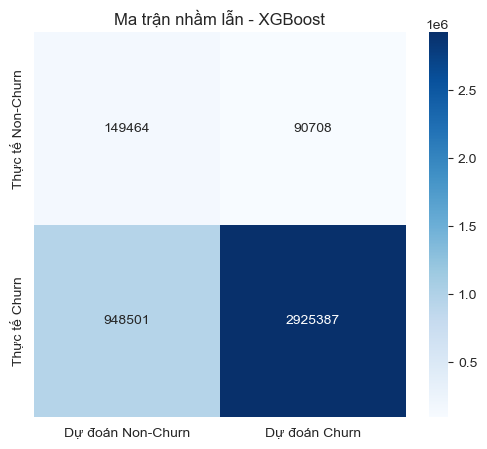

In [5]:
# --- CELL 5: MÔ HÌNH 1 - XGBOOST (GPU & LƯU FILE) ---
print("\nBắt đầu huấn luyện mô hình XGBoost trên GPU...")
X_train = df_train_full[features]; y_train = df_train_full[target]
X_val = df_val[features]; y_val = df_val[target]
X_test = df_test[features]; y_test = df_test[target]

if 1 in y_train.value_counts() and y_train.value_counts()[1] > 0:
    ratio = y_train.value_counts()[0] / y_train.value_counts()[1]
else:
    ratio = 1

xgb_model = XGBClassifier(
    objective='binary:logistic', eval_metric='logloss', use_label_encoder=False,
    scale_pos_weight=ratio, n_estimators=1000, learning_rate=0.05,
    max_depth=6, subsample=0.8, colsample_bytree=0.8,
    early_stopping_rounds=50, random_state=42,
    tree_method='gpu_hist'
)
xgb_model.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=False)
print(f"✅ Huấn luyện XGBoost hoàn tất. Số cây tối ưu: {xgb_model.best_iteration}")

xgb_model_path = "best_xgboost_model.json"
xgb_model.save_model(xgb_model_path)
print(f"✅ Mô hình XGBoost đã được lưu vào file: {xgb_model_path}")

y_pred_xgb = xgb_model.predict(X_test); y_proba_xgb = xgb_model.predict_proba(X_test)[:, 1]
print("\n--- 📊 KẾT QUẢ XGBOOST TRÊN TẬP TEST ---")
print(classification_report(y_test, y_pred_xgb, target_names=['Non-Churn (0)', 'Churn (1)']))
roc_auc_xgb = roc_auc_score(y_test, y_proba_xgb); f1_xgb = f1_score(y_test, y_pred_xgb)
print(f"🚀 F1-Score: {f1_xgb:.4f}"); print(f"🚀 ROC AUC Score: {roc_auc_xgb:.4f}")
plt.figure(figsize=(6,5)); cm = confusion_matrix(y_test, y_pred_xgb); sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Dự đoán Non-Churn', 'Dự đoán Churn'], yticklabels=['Thực tế Non-Churn', 'Thực tế Churn']); plt.title('Ma trận nhầm lẫn - XGBoost'); plt.show()

Tạo sequence (dài 2): 100%|██████████| 8962266/8962266 [1:24:08<00:00, 1775.31it/s]



Bắt đầu huấn luyện LSTM trên CUDA...
Epoch [1/50], Val Loss: 0.1431
Epoch [2/50], Val Loss: 0.1416
Epoch [3/50], Val Loss: 0.1411
Epoch [4/50], Val Loss: 0.1392
Epoch [5/50], Val Loss: 0.1360
Epoch [6/50], Val Loss: 0.1342
Epoch [7/50], Val Loss: 0.1363
Epoch [8/50], Val Loss: 0.1312
Epoch [9/50], Val Loss: 0.1309
Epoch [10/50], Val Loss: 0.1344
Epoch [11/50], Val Loss: 0.1330
Epoch [12/50], Val Loss: 0.1360
Epoch [13/50], Val Loss: 0.1338
Epoch [14/50], Val Loss: 0.1334
Early stopping!
✅ Huấn luyện LSTM hoàn tất. Mô hình tốt nhất đã được lưu vào 'best_lstm_model.pth'

--- 📊 KẾT QUẢ LSTM TRÊN TẬP TEST ---
               precision    recall  f1-score   support

Non-Churn (0)       0.18      0.54      0.27    108325
    Churn (1)       0.92      0.69      0.79    855862

     accuracy                           0.68    964187
    macro avg       0.55      0.62      0.53    964187
 weighted avg       0.84      0.68      0.73    964187

🚀 F1-Score: 0.7912
🚀 ROC AUC Score: 0.6562


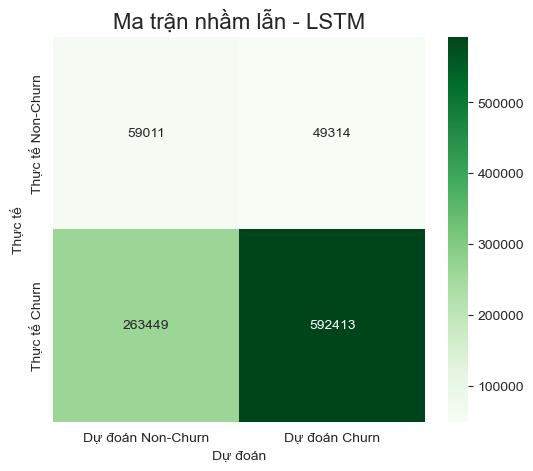

In [6]:
# --- CELL 6: MÔ HÌNH 2 - LSTM (GPU & LƯU FILE) ---
SEQUENCE_LENGTH = 2
def create_sequences(df, features, target, sequence_length):
    X_seq, y_seq, groups, month_seq = [], [], [], []
    user_groups = df.groupby('user_id')
    for user_id, group in tqdm(user_groups, desc=f"Tạo sequence (dài {sequence_length})"):
        data = group[features].values; labels = group[target].values; months = group['month'].values
        if len(data) > sequence_length:
            for i in range(len(data) - sequence_length):
                X_seq.append(data[i:i+sequence_length]); y_seq.append(labels[i+sequence_length]); groups.append(user_id); month_seq.append(months[i+sequence_length])
    return np.array(X_seq), np.array(y_seq), np.array(groups), np.array(month_seq)

X_train_val, y_train_val, _, _ = create_sequences(df_train_full, features, target, sequence_length=SEQUENCE_LENGTH)
df_for_test_seq = df_processed[df_processed.time_idx >= (test_cutoff - SEQUENCE_LENGTH)]
X_test_seq, y_test_seq, groups_test_lstm, months_test_lstm = create_sequences(df_for_test_seq, features, target, sequence_length=SEQUENCE_LENGTH)

if len(X_train_val) == 0:
    print("\nCẢNH BÁO: Không tạo được sequence nào cho LSTM. Bỏ qua việc huấn luyện.")
    roc_auc_lstm, f1_lstm = 0.5, 0.0
    df_lstm_results = pd.DataFrame(columns=['user_id', 'LSTM', 'month'])
else:
    X_train_seq, X_val_seq, y_train_seq, y_val_seq = train_test_split(X_train_val, y_train_val, test_size=0.15, random_state=42, stratify=y_train_val)
    X_train_tensor, y_train_tensor = torch.tensor(X_train_seq.astype(np.float32)), torch.tensor(y_train_seq.astype(np.float32)).unsqueeze(1)
    X_val_tensor, y_val_tensor = torch.tensor(X_val_seq.astype(np.float32)), torch.tensor(y_val_seq.astype(np.float32)).unsqueeze(1)
    X_test_tensor, y_test_tensor = torch.tensor(X_test_seq.astype(np.float32)), torch.tensor(y_test_seq.astype(np.float32)).unsqueeze(1)
    class ChurnDataset(Dataset):
        def __init__(self, X, y): self.X, self.y = X, y
        def __len__(self): return len(self.X)
        def __getitem__(self, idx): return self.X[idx], self.y[idx]
    train_loader = DataLoader(ChurnDataset(X_train_tensor, y_train_tensor), batch_size=512, shuffle=True)
    val_loader = DataLoader(ChurnDataset(X_val_tensor, y_val_tensor), batch_size=512, shuffle=False)
    test_loader = DataLoader(ChurnDataset(X_test_tensor, y_test_tensor), batch_size=512, shuffle=False)
    class LSTMChurn(nn.Module):
        def __init__(self, input_size, hidden_size, n_layers=2):
            super().__init__(); self.lstm = nn.LSTM(input_size, hidden_size, n_layers, batch_first=True, dropout=0.3); self.fc = nn.Linear(hidden_size, 1)
        def forward(self, x): out, _ = self.lstm(x); out = self.fc(out[:, -1, :]); return out

    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model_lstm = LSTMChurn(input_size=len(features), hidden_size=128).to(device)
    neg_count = np.sum(y_train_seq == 0); pos_count = np.sum(y_train_seq == 1)
    pos_weight = torch.tensor([neg_count / pos_count if pos_count > 0 else 1], dtype=torch.float).to(device)
    criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
    optimizer = torch.optim.Adam(model_lstm.parameters(), lr=0.001)
    patience = 5; best_val_loss = float('inf'); epochs_no_improve = 0;
    lstm_model_path = "best_lstm_model.pth"

    print(f"\nBắt đầu huấn luyện LSTM trên {device.upper()}...")
    for epoch in range(50):
        model_lstm.train()
        for batch_X, batch_y in train_loader:
            outputs = model_lstm(batch_X.to(device)); loss = criterion(outputs, batch_y.to(device))
            optimizer.zero_grad(); loss.backward(); optimizer.step()
        model_lstm.eval(); val_loss = 0
        with torch.no_grad():
            for batch_X, batch_y in val_loader:
                outputs = model_lstm(batch_X.to(device)); val_loss += criterion(outputs, batch_y.to(device)).item()
        val_loss /= len(val_loader)
        print(f'Epoch [{epoch+1}/50], Val Loss: {val_loss:.4f}')
        if val_loss < best_val_loss:
            best_val_loss = val_loss; epochs_no_improve = 0; torch.save(model_lstm.state_dict(), lstm_model_path)
        else: epochs_no_improve += 1
        if epochs_no_improve == patience: print("Early stopping!"); break
            
    print(f"✅ Huấn luyện LSTM hoàn tất. Mô hình tốt nhất đã được lưu vào '{lstm_model_path}'")
    model_lstm.load_state_dict(torch.load(lstm_model_path))
    
    model_lstm.eval(); all_probs_lstm, all_labels_lstm = [], []
    with torch.no_grad():
        for batch_X, batch_y in test_loader:
            outputs = model_lstm(batch_X.to(device)); all_probs_lstm.extend(torch.sigmoid(outputs).cpu().numpy()); all_labels_lstm.extend(batch_y.cpu().numpy())
    y_proba_lstm = np.array(all_probs_lstm); y_true_lstm = np.array(all_labels_lstm); y_pred_lstm = (y_proba_lstm > 0.5).astype(int)
    df_lstm_results = pd.DataFrame({'user_id': groups_test_lstm, 'LSTM': y_pred_lstm.flatten(), 'month': pd.to_datetime(months_test_lstm)})
    print("\n--- 📊 KẾT QUẢ LSTM TRÊN TẬP TEST ---")
    print(classification_report(y_true_lstm, y_pred_lstm, target_names=['Non-Churn (0)', 'Churn (1)'])); roc_auc_lstm = roc_auc_score(y_true_lstm, y_proba_lstm); f1_lstm = f1_score(y_true_lstm, y_pred_lstm)
    print(f"🚀 F1-Score: {f1_lstm:.4f}"); print(f"🚀 ROC AUC Score: {roc_auc_lstm:.4f}")
    plt.figure(figsize=(6, 5)); cm_lstm = confusion_matrix(y_true_lstm, y_pred_lstm); sns.heatmap(cm_lstm, annot=True, fmt='d', cmap='Greens', xticklabels=['Dự đoán Non-Churn', 'Dự đoán Churn'], yticklabels=['Thực tế Non-Churn', 'Thực tế Churn']); plt.title('Ma trận nhầm lẫn - LSTM', fontsize=16); plt.xlabel('Dự đoán'); plt.ylabel('Thực tế'); plt.show()

In [7]:
# --- CELL 7 (PHIÊN BẢN SỬA LỖI TRIỆT ĐỂ) ---
# CHUẨN BỊ DỮ LIỆU CHO TFT

print("\nChuẩn bị dữ liệu cho TFT...")
df_tft = df_processed.copy()
df_tft.rename(columns={'user_id': 'group'}, inplace=True)
df_tft['purchase_count'] = df_tft['purchase_count'].astype(float)

max_encoder_length = 3
max_prediction_length = 1
min_len_tft = max_encoder_length + max_prediction_length

user_lengths = df_tft.groupby('group').size()
valid_users = user_lengths[user_lengths >= min_len_tft].index
df_tft_filtered = df_tft[df_tft['group'].isin(valid_users)]
print(f"TFT: Lọc từ {df_tft['group'].nunique()} users xuống còn {len(valid_users)} users có đủ dữ liệu.")

# === THAY ĐỔI LOGIC TẠO DATASET Ở ĐÂY ===
# Tạo một dataset tổng trên toàn bộ dữ liệu hợp lệ
# Encoder sẽ học từ tất cả các category có thể có
full_dataset = TimeSeriesDataSet(
    df_tft_filtered,
    time_idx="time_idx",
    target="purchase_count",
    group_ids=["group"],
    min_encoder_length=1, 
    max_encoder_length=max_encoder_length,
    min_prediction_length=max_prediction_length,
    max_prediction_length=max_prediction_length,
    time_varying_known_categoricals=["month_of_year"],
    time_varying_unknown_reals=["event_count", "total_spent", "n_categories", "time_idx"],
    target_normalizer=GroupNormalizer(groups=["group"], transformation="softplus"),
    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True,
    allow_missing_timesteps=True
)

# Từ dataset tổng, dùng .filter() để tạo tập training
training_cutoff = df_tft_filtered["time_idx"].max() - max_prediction_length
training_dataset = TimeSeriesDataSet.from_dataset(full_dataset, df_tft_filtered[lambda x: x.time_idx <= training_cutoff], stop_randomization=True)

# Tạo dataloader
batch_size = 128
train_dataloader = training_dataset.to_dataloader(train=True, batch_size=batch_size, num_workers=0)
val_dataloader = full_dataset.to_dataloader(train=False, batch_size=batch_size*10, num_workers=0)

print("\n✅ Chuẩn bị dữ liệu cho TFT hoàn tất theo cách làm chuẩn.")


Chuẩn bị dữ liệu cho TFT...
TFT: Lọc từ 13529831 users xuống còn 1489844 users có đủ dữ liệu.

✅ Chuẩn bị dữ liệu cho TFT hoàn tất theo cách làm chuẩn.


In [ ]:
# --- CELL 8: MÔ HÌNH 3 - TFT (GPU & LƯU FILE) ---
pl.seed_everything(42)
checkpoint_callback = ModelCheckpoint(dirpath="tft_checkpoints/", filename="best-tft-model", save_top_k=1, monitor="val_loss", mode="min")
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=10, verbose=False, mode="min")
trainer = pl.Trainer(
max_time="00:04:00:00",
gpus=1,
gradient_clip_val=0.1,
callbacks=[early_stop_callback, checkpoint_callback]
)
tft_model = TemporalFusionTransformer.from_dataset(training_dataset, learning_rate=0.01, hidden_size=64, attention_head_size=4,
                                                 dropout=0.1, hidden_continuous_size=32, output_size=7, loss=QuantileLoss(),
                                                 log_interval=-1, reduce_on_plateau_patience=4)

print(f"\nBắt đầu huấn luyện TFT trên GPU...")
trainer.fit(tft_model, train_dataloaders=train_dataloader, val_dataloaders=val_dataloader)
print("✅ Huấn luyện TFT hoàn tất.")

best_model_path = trainer.checkpoint_callback.best_model_path
print(f"✅ Mô hình TFT tốt nhất đã được tự động lưu vào file: {best_model_path}")
best_tft = TemporalFusionTransformer.load_from_checkpoint(best_model_path)

test_data_for_tft = df_tft_filtered[lambda x: x.time_idx > training_dataset.data["time_idx"].max() - max_encoder_length]
test_dataloader = TimeSeriesDataSet.from_dataset(training_dataset, test_data_for_tft, predict=False, stop_randomization=True).to_dataloader(train=False, batch_size=batch_size*10)
predictions_tft_raw = best_tft.predict(test_dataloader, return_y=True, trainer_kwargs=dict(accelerator="auto"))
predictions_tft = predictions_tft_raw.output.squeeze().cpu().numpy()
df_test_tft = test_data_for_tft[test_data_for_tft.time_idx > training_dataset.data["time_idx"].max()].copy()
df_test_tft['predicted_purchase'] = predictions_tft
y_true_tft = df_test_tft['churn']; y_pred_tft = (df_test_tft['predicted_purchase'] <= 0.5).astype(int); y_proba_tft = 1 / (1 + np.exp(-df_test_tft['predicted_purchase']))
print("\n--- 📊 KẾT QUẢ TFT TRÊN TẬP TEST ---")
print(classification_report(y_true_tft, y_pred_tft)); roc_auc_tft = roc_auc_score(y_true_tft, y_proba_tft); f1_tft = f1_score(y_true_tft, y_pred_tft)
print(f"🚀 F1-Score: {f1_tft:.4f}"); print(f"🚀 ROC AUC Score: {roc_auc_tft:.4f}")
plt.figure(figsize=(6, 5)); cm_tft = confusion_matrix(y_true_tft, y_pred_tft); sns.heatmap(cm_tft, annot=True, fmt='d', cmap='Oranges', xticklabels=['Dự đoán Non-Churn', 'Dự đoán Churn'], yticklabels=['Thực tế Non-Churn', 'Thực tế Churn']); plt.title('Ma trận nhầm lẫn - TFT', fontsize=16); plt.xlabel('Dự đoán'); plt.ylabel('Thực tế'); plt.show()

Global seed set to 42
c:\Users\nguye\anaconda3\envs\timeseries_gpu\lib\site-packages\pytorch_lightning\trainer\connectors\accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  rank_zero_deprecation(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 4050 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                               | Type                            | Params
----


Bắt đầu huấn luyện TFT trên GPU...
Epoch 0:   8%|▊         | 5000/60296 [3:59:26<44:08:01,  2.87s/it, loss=0.189, v_num=3, train_loss_step=0.289] 

Time limit reached. Elapsed time is 4:02:21. Signaling Trainer to stop.


Epoch 0:  16%|█▋        | 9834/60296 [5:23:35<27:40:29,  1.97s/it, loss=0.193, v_num=3, train_loss_step=0.175]

In [ ]:
# --- CELL 9: SO SÁNH KẾT QUẢ CÁC MÔ HÌNH ---
print("\nTổng hợp kết quả từ 3 mô hình trên tập Test...")
if 'roc_auc_lstm' not in locals(): roc_auc_lstm, f1_lstm = 0.5, 0.0
if 'roc_auc_tft' not in locals(): roc_auc_tft, f1_tft = 0.5, 0.0
results = pd.DataFrame({'Model': ['XGBoost', 'LSTM', 'TFT'], 'ROC AUC': [roc_auc_xgb, roc_auc_lstm, roc_auc_tft], 'F1-Score (for Churn=1)': [f1_xgb, f1_lstm, f1_tft]})
results = results.sort_values(by='ROC AUC', ascending=False).reset_index(drop=True)
print("\nBảng so sánh hiệu suất:")
print(results)
plt.figure(figsize=(16, 6)); plt.subplot(1, 2, 1); sns.barplot(data=results, x='Model', y='ROC AUC', palette='mako'); plt.title('So sánh ROC AUC Score', fontsize=16)
plt.subplot(1, 2, 2); sns.barplot(data=results, x='Model', y='F1-Score (for Churn=1)', palette='rocket'); plt.title('So sánh F1-Score (cho lớp Churn)', fontsize=16); plt.tight_layout(); plt.show()

In [ ]:
# --- CELL 10: TRỰC QUAN HÓA SO SÁNH THEO THỜI GIAN ---
print("\nBắt đầu tổng hợp kết quả để trực quan hóa...")
actual_churn_rate = df_processed.groupby('month')['churn'].mean().reset_index(); actual_churn_rate.rename(columns={'churn': 'Thực tế'}, inplace=True)
xgb_results_df = df_test[['month']].copy(); xgb_results_df['XGBoost'] = y_pred_xgb; xgb_predicted_rate = xgb_results_df.groupby('month')['XGBoost'].mean().reset_index()
if 'df_lstm_results' in locals() and not df_lstm_results.empty: lstm_predicted_rate = df_lstm_results.groupby('month')['LSTM'].mean().reset_index()
else: lstm_predicted_rate = pd.DataFrame(columns=['month', 'LSTM'])
if 'df_test_tft' in locals() and not df_test_tft.empty: df_test_tft['TFT'] = y_pred_tft; tft_predicted_rate = df_test_tft.groupby('month')['TFT'].mean().reset_index()
else: tft_predicted_rate = pd.DataFrame(columns=['month', 'TFT'])

final_plot_df = actual_churn_rate.set_index('month')
plot_data_list = [xgb_predicted_rate, lstm_predicted_rate, tft_predicted_rate]
for df in plot_data_list:
    if not df.empty:
        df = df.set_index('month'); final_plot_df = final_plot_df.merge(df, on='month', how='left')

plt.figure(figsize=(20, 10))
plt.plot(final_plot_df.index, final_plot_df['Thực tế'], label='Thực tế', color='black', linewidth=2.5, zorder=5)
for model_col, color, marker, ls in zip(['XGBoost', 'LSTM', 'TFT'], ['blue', 'magenta', 'green'], ['o', 's', '^'], ['--', ':', '-.']):
    subset = final_plot_df[[model_col]].dropna()
    if not subset.empty:
         plt.plot(subset.index, subset[model_col], label=model_col, color=color, marker=marker, linestyle='None', markersize=10)
plt.title('So sánh Tỷ lệ Churn Thực tế và Dự báo', fontsize=20)
plt.xlabel('Ngày'); plt.ylabel('Tỷ lệ churn'); plt.legend(fontsize=12, loc='best'); plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()
